# KTR Pyro Examples

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
from orbit.models.ktr import KTRFull, KTRAggregated, KTRMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [5]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [6]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [7]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [8]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Pyro Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [66]:
level_knot_dates

array(['2010-05-23T00:00:00.000000000', '2011-02-27T00:00:00.000000000',
       '2011-12-04T00:00:00.000000000', '2012-09-09T00:00:00.000000000',
       '2013-06-16T00:00:00.000000000', '2014-03-23T00:00:00.000000000',
       '2014-12-28T00:00:00.000000000', '2015-10-04T00:00:00.000000000',
       '2016-07-10T00:00:00.000000000', '2017-04-16T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [67]:
level_knots_stan

array([13.04195541, 12.92689436, 12.84990086, 12.80494118, 12.73417963,
       12.66677508, 12.54623141, 12.4911475 , 12.4651431 , 12.3696503 ])

In [68]:
ktr_vi = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] * 3,
    
    level_knot_scale = .000001,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=200,
    estimator_type=PyroEstimatorVI,
)

In [70]:
%%time
ktr_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 7.915e+05, scale = 0.09391
step  100 loss = 1.2584e+05, scale = 0.65573
step  200 loss = 96910, scale = 0.67206
step  300 loss = 1.1213e+05, scale = 0.66725
step  400 loss = 1.263e+05, scale = 0.66372
step  500 loss = 1.2418e+05, scale = 0.67174
step  600 loss = 79751, scale = 0.67519
step  700 loss = 1.159e+05, scale = 0.66857
step  800 loss = 86403, scale = 0.6628
step  900 loss = 73757, scale = 0.66817
CPU times: user 2min 52s, sys: 7.75 s, total: 2min 59s
Wall time: 18.1 s


In [71]:
predicted_df = ktr_vi.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,11.68755,12.35917,12.98447
1,2017-07-09,11.69308,12.35723,12.93999
2,2017-07-16,11.77374,12.35971,13.09104
3,2017-07-23,11.78886,12.38447,13.11994
4,2017-07-30,11.82392,12.46737,12.98957


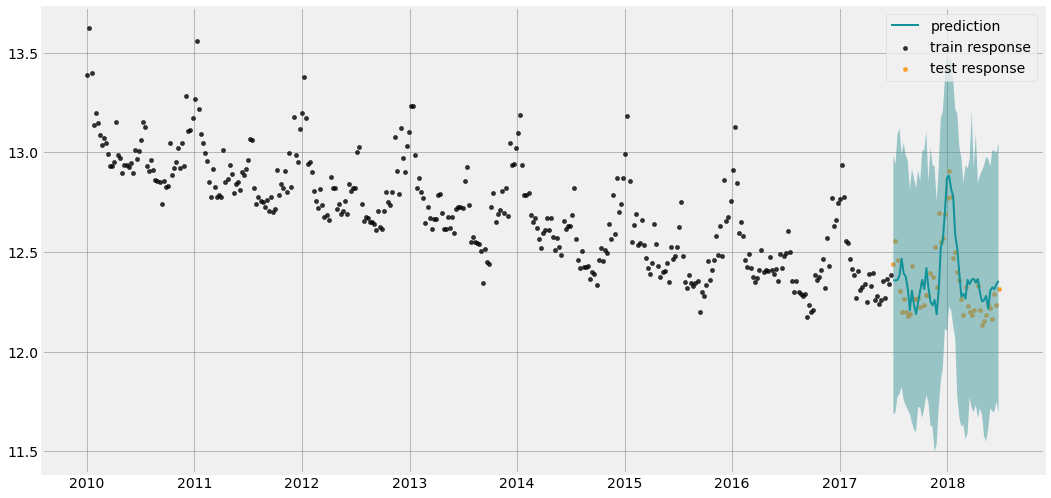

In [72]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [41]:
coef_df = ktr_vi.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.55440,0.16239,0.33667
1,2010-01-10,0.55579,0.16296,0.33656
2,2010-01-17,0.55719,0.16355,0.33645
3,2010-01-24,0.55862,0.16414,0.33634
4,2010-01-31,0.56008,0.16474,0.33623


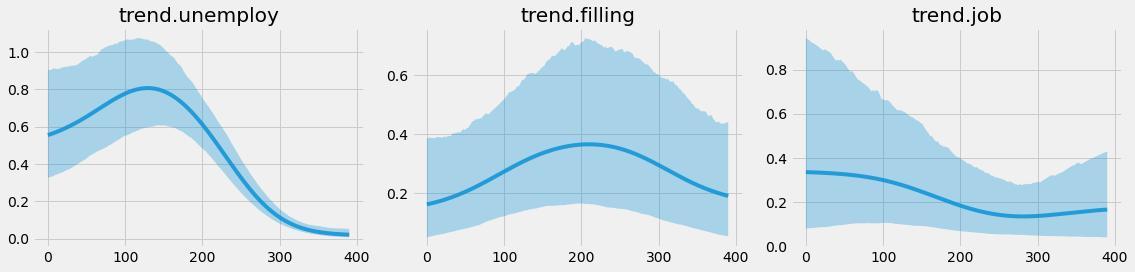

In [42]:
_ = ktr_vi.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## Pyro Fit and Predict - Aggregated

In [18]:
ktr_vi_agg = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [19]:
%%time
ktr_vi_agg.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 3min 4s, sys: 3.15 s, total: 3min 7s
Wall time: 17.3 s


In [20]:
predicted_df = ktr_vi_agg.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.43627,12.17022,0.03457,0.23147
1,2017-07-09,12.42480,12.17001,0.00824,0.24655
2,2017-07-16,12.34259,12.16981,-0.00967,0.18245
3,2017-07-23,12.31712,12.16963,-0.00258,0.15007
4,2017-07-30,12.33596,12.16947,-0.01219,0.17867


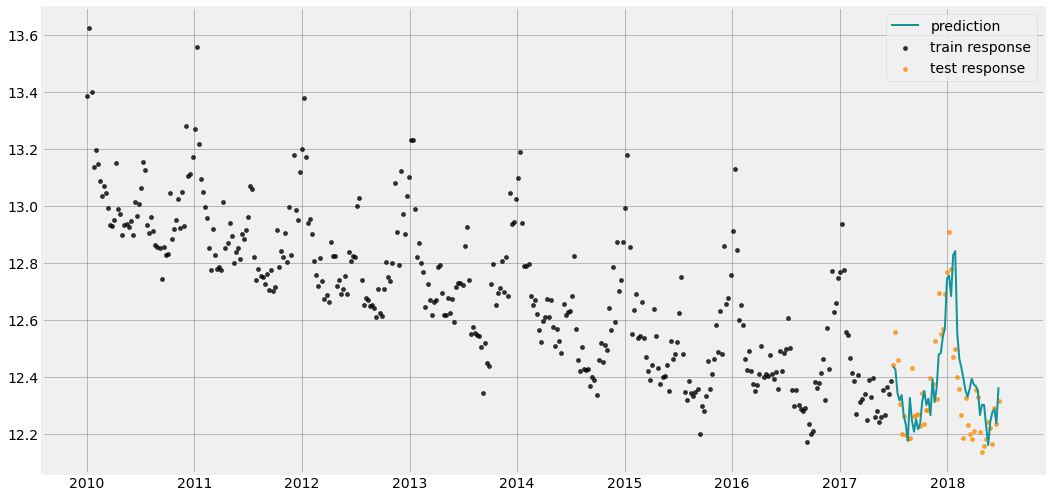

In [21]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [26]:
coef_df = ktr_vi_agg.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.31985,1.07427,0.09461
1,2010-01-10,0.32501,1.07104,0.09448
2,2010-01-17,0.33026,1.06775,0.09435
3,2010-01-24,0.33558,1.06442,0.09421
4,2010-01-31,0.34098,1.06102,0.09408


In [27]:
# extract future coefficients
coef_df2 = ktr_vi_agg.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,1.17220,0.39123,0.04131
1,2017-07-09,1.17601,0.38868,0.04133
2,2017-07-16,1.17976,0.38617,0.04135
3,2017-07-23,1.18344,0.38371,0.04137
4,2017-07-30,1.18705,0.38128,0.04139


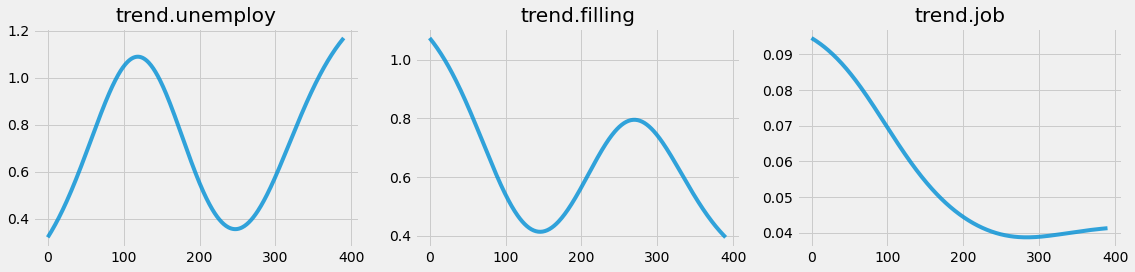

In [28]:
_ = ktr_vi_agg.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Pyro Fit and Predict - MAP

In [73]:
seasonal_knots_mean_stan

array([ 0.12836781,  0.03496329,  0.14181474, -0.00338865,  0.02171374,
       -0.00727571,  0.04303702,  0.05156487, -0.00087458,  0.00800036])

In [80]:
ktr_map = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_sign=['='] *3,
    
    level_knot_scale = .01,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,
    seasonal_knot_loc = seasonal_knots_mean_stan,
    
    
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
    seasonal_knot_pooling_scale=.01,
    seasonal_knot_scale=.01,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    estimator_type=PyroEstimatorMAP,
)

In [81]:
ktr_map._seasonal_knot_loc

array([ 0.12836781,  0.03496329,  0.14181474, -0.00338865,  0.02171374,
       -0.00727571,  0.04303702,  0.05156487, -0.00087458,  0.00800036])

In [86]:
ktr_map._aggregate_posteriors['map']['coef_knot'][0].mean(axis=1)

array([1.26293749e-01, 3.54613181e-02, 1.44104273e-01, 5.78333794e-04,
       2.12841347e-02, 3.81103586e-12, 4.43442937e-02, 5.23329608e-02,
       4.68365977e-04, 3.15403147e-03])

In [82]:
%%time
ktr_map.fit(df=train_df)

CPU times: user 16.7 s, sys: 116 ms, total: 16.8 s
Wall time: 2.82 s


In [83]:
predicted_df = ktr_map.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.41488,12.37000,0.04487,0.00000
1,2017-07-09,12.41408,12.37000,0.04408,0.00000
2,2017-07-16,12.39615,12.37000,0.02615,0.00000
3,2017-07-23,12.36271,12.37000,-0.00730,0.00000
4,2017-07-30,12.31815,12.37000,-0.05185,0.00000


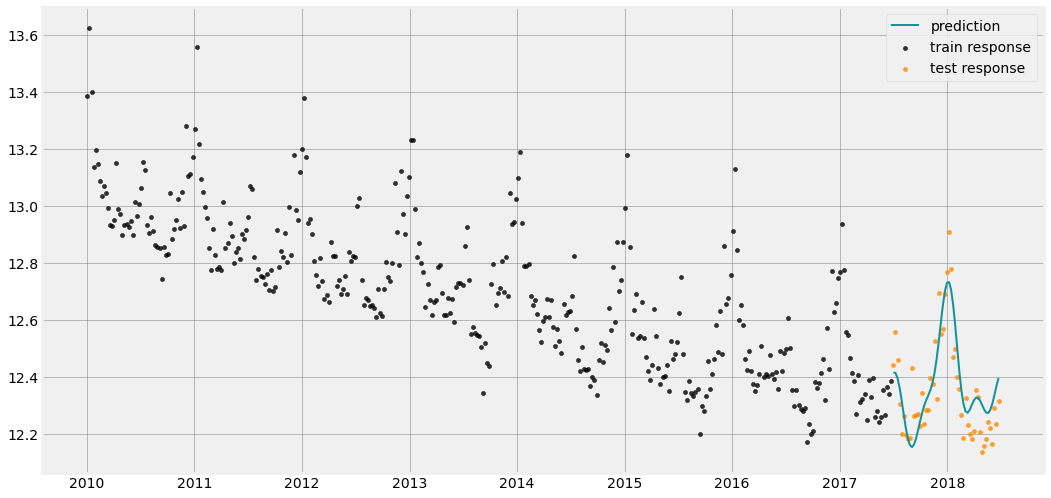

In [84]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [43]:
ktr_map._aggregate_posteriors['map']['lev_knot']

array([[13.04130814, 12.95987171, 12.86272309, 12.83090094, 12.73729523,
        12.66464845, 12.55438745, 12.45213763, 12.49667596, 12.37015968]])

In [44]:
level_knots_stan

array([13.04195541, 12.92689436, 12.84990086, 12.80494118, 12.73417963,
       12.66677508, 12.54623141, 12.4911475 , 12.4651431 , 12.3696503 ])

In [33]:
coef_df = ktr_map.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.28993,0.24448,0.00000
1,2010-01-10,0.29556,0.24537,0.00000
2,2010-01-17,0.30128,0.24628,0.00000
3,2010-01-24,0.30709,0.24719,0.00000
4,2010-01-31,0.31299,0.24812,0.00000


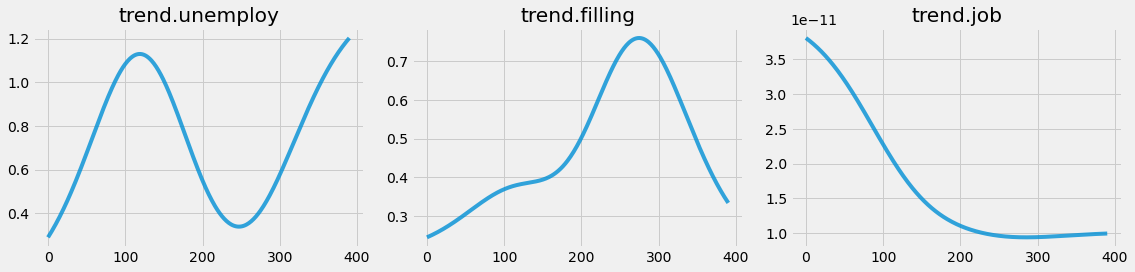

In [34]:
_ = ktr_map.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Stan MCMC Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [119]:
ktr_vi = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=20,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = .5,
#     regressor_knot_pooling_loc=[0] * 3,
#     regressor_knot_pooling_scale=[.1] * 3,
#     regressor_knot_scale=[1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
#     num_warmup = num_warmup
#     num_sample = num_sample
    n_bootstrap_draws=-1,
    estimator_type=StanEstimatorMCMC,
)

In [120]:
%%time
ktr_vi.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 500 ms, sys: 491 ms, total: 991 ms
Wall time: 42.9 s


In [121]:
predicted_df = ktr_vi.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.94986,13.23665,13.52311
1,2017-07-09,12.47660,12.90141,13.24846
2,2017-07-16,11.82370,12.23190,12.72546
3,2017-07-23,11.45541,11.81732,12.13998
4,2017-07-30,11.18727,11.55273,11.88276


In [122]:
predicted_df = ktr_vi.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.94986,13.23665,13.52311
1,2017-07-09,12.47660,12.90141,13.24846
2,2017-07-16,11.82370,12.23190,12.72546
3,2017-07-23,11.45541,11.81732,12.13998
4,2017-07-30,11.18727,11.55273,11.88276


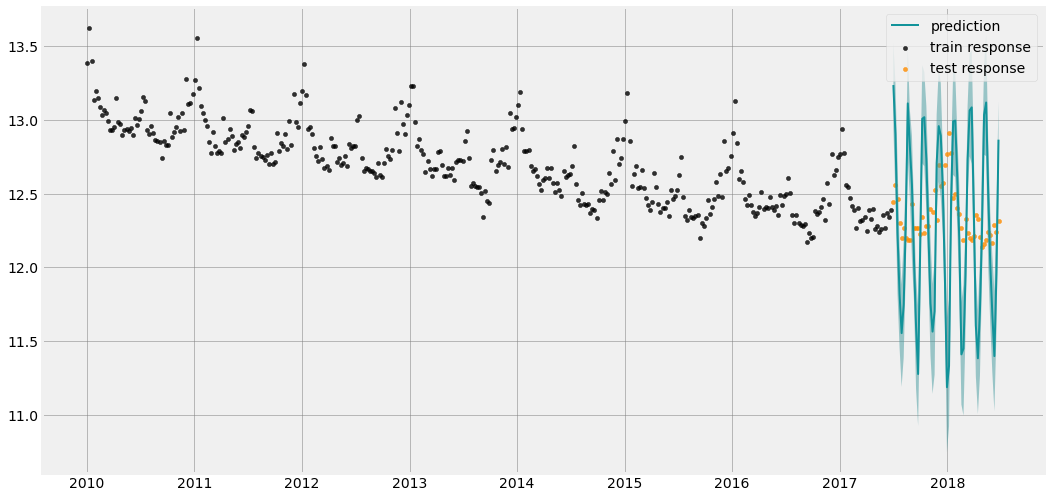

In [123]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [38]:
coef_df = ktr_vi.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,-0.02364,0.00414,0.01546
1,2010-01-10,-0.02357,0.00411,0.01540
2,2010-01-17,-0.02351,0.00409,0.01534
3,2010-01-24,-0.02345,0.00406,0.01528
4,2010-01-31,-0.02338,0.00403,0.01522


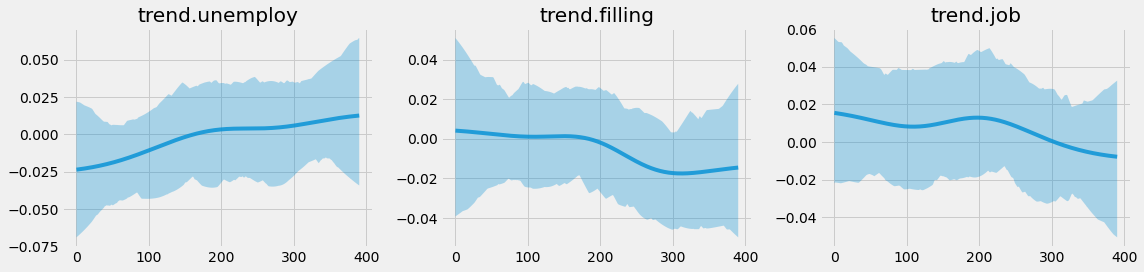

In [39]:
_ = ktr_vi.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## Stan Fit and Predict - Aggregated

In [40]:
ktr_vi_agg = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    aggregate_method='median',
    estimator_type=StanEstimatorMCMC,
)

In [41]:
%%time
ktr_vi_agg.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 138 ms, sys: 93.6 ms, total: 231 ms
Wall time: 28.1 s


In [42]:
predicted_df = ktr_vi_agg.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,13.34117,12.15949,1.18105,0.00064
1,2017-07-09,12.54931,12.15949,0.38814,0.00169
2,2017-07-16,11.54755,12.15949,-0.61241,0.00047
3,2017-07-23,10.96186,12.15949,-1.19838,0.00075
4,2017-07-30,11.12620,12.15949,-1.03373,0.00045


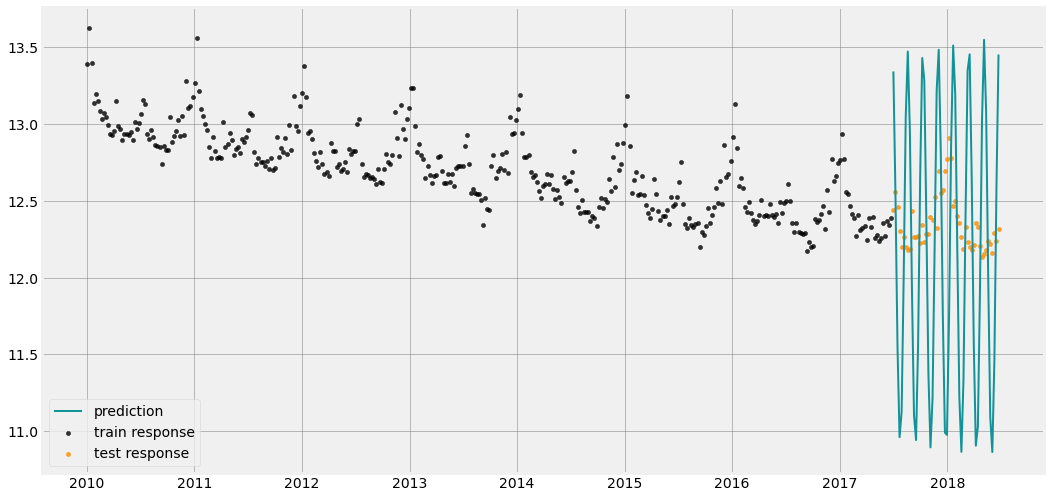

In [43]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [26]:
coef_df = ktr_vi_agg.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.31985,1.07427,0.09461
1,2010-01-10,0.32501,1.07104,0.09448
2,2010-01-17,0.33026,1.06775,0.09435
3,2010-01-24,0.33558,1.06442,0.09421
4,2010-01-31,0.34098,1.06102,0.09408


In [44]:
# extract future coefficients
coef_df2 = ktr_vi_agg.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,0.01139,-0.01942,-0.00652
1,2017-07-09,0.01145,-0.01940,-0.00660
2,2017-07-16,0.01151,-0.01938,-0.00667
3,2017-07-23,0.01157,-0.01936,-0.00674
4,2017-07-30,0.01163,-0.01934,-0.00681


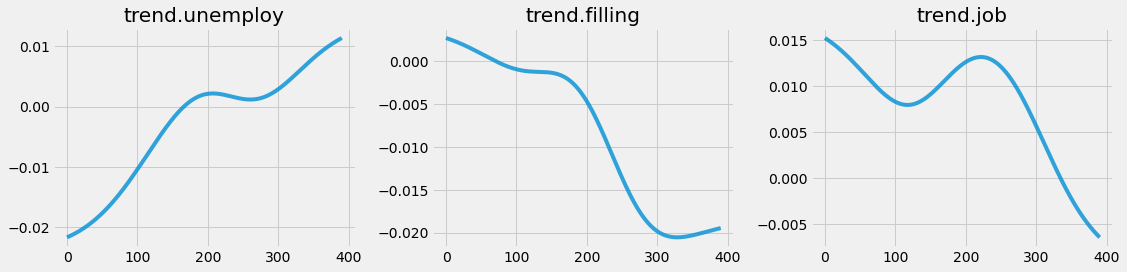

In [45]:
_ = ktr_vi_agg.plot_regression_coefs(ncol=3, figsize=(16, 4))

## Stan Fit and Predict - MAP

In [9]:
365.25/7

52.17857142857143

In [53]:
ktr_map_stan = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_sign=['+'] *3,
    
    level_knot_scale = .5,
   # regressor_knot_pooling_loc=[0] * 3,
  #  regressor_knot_pooling_scale=[.1] * 3,
  #  regressor_knot_scale=[1] * 3,
#     rho_level=0.1, # doesn't matter anymore
span_level= .1, # 1 knot per quarter # 3 months / 36 total months of train
    rho_coefficients=0.15,
    span_coefficients=0.2,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    estimator_type=StanEstimatorMAP,
)

In [54]:
%%time
ktr_map_stan.fit(df=train_df)

CPU times: user 216 ms, sys: 6.62 ms, total: 223 ms
Wall time: 221 ms


In [55]:
predicted_df = ktr_map_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.38503,12.36965,0.01538,0.00000
1,2017-07-09,12.38691,12.36965,0.01726,0.00000
2,2017-07-16,12.37853,12.36965,0.00888,0.00000
3,2017-07-23,12.35849,12.36965,-0.01116,0.00000
4,2017-07-30,12.32664,12.36965,-0.04301,0.00000


In [56]:
level_knots_stan = ktr_map_stan._aggregate_posteriors['map']['lev_knot'][0]

In [57]:
len(level_knots_stan)

10

In [58]:
level_knot_dates = ktr_map_stan._level_knot_dates
level_knot_dates

array(['2010-05-23T00:00:00.000000000', '2011-02-27T00:00:00.000000000',
       '2011-12-04T00:00:00.000000000', '2012-09-09T00:00:00.000000000',
       '2013-06-16T00:00:00.000000000', '2014-03-23T00:00:00.000000000',
       '2014-12-28T00:00:00.000000000', '2015-10-04T00:00:00.000000000',
       '2016-07-10T00:00:00.000000000', '2017-04-16T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [59]:
#ktr_map._aggregate_posteriors['map']['lev'] ## fix?

In [60]:
ktr_map_stan._coef_knot_dates

array(['2010-10-10T00:00:00.000000000', '2012-04-15T00:00:00.000000000',
       '2013-10-20T00:00:00.000000000', '2015-04-26T00:00:00.000000000',
       '2016-10-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [70]:
seasonal_knots_mean_stan = ktr_map_stan._aggregate_posteriors['map']['coef_knot'][0].mean(axis=1)

In [31]:
predicted_df = ktr_map.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.38503,12.36965,0.01538,0.00000
1,2017-07-09,12.38691,12.36965,0.01726,0.00000
2,2017-07-16,12.37853,12.36965,0.00888,0.00000
3,2017-07-23,12.35849,12.36965,-0.01116,0.00000
4,2017-07-30,12.32664,12.36965,-0.04301,0.00000


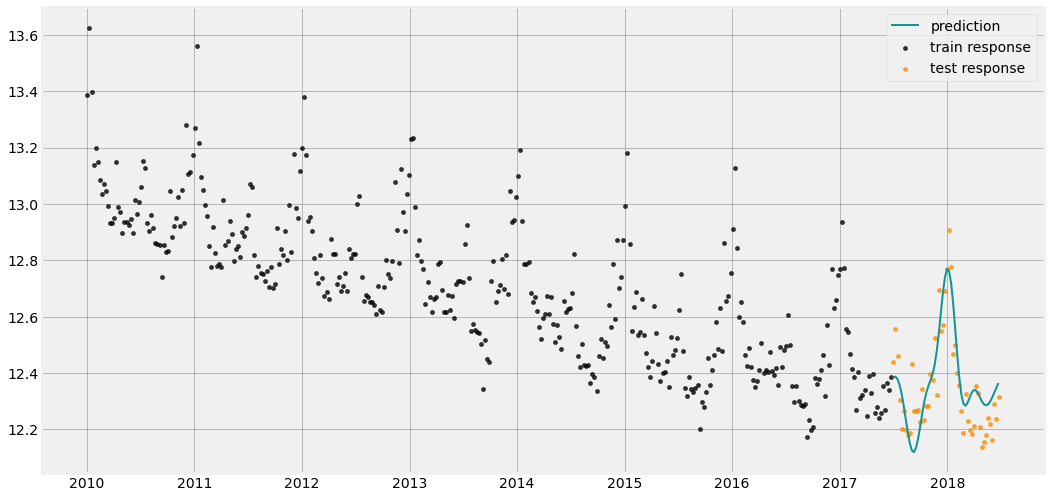

In [32]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [48]:
ktr_map._response_mean

0

In [134]:
coef_df = ktr_map.get_regression_coefs()
coef_df.head()

,week
0,2010-01-03
1,2010-01-10
2,2010-01-17
3,2010-01-24
4,2010-01-31


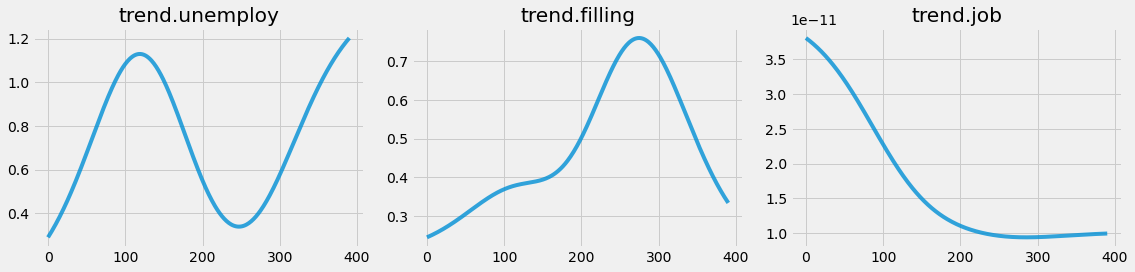

In [34]:
_ = ktr_map.plot_regression_coefs(ncol=3, figsize=(16, 4))

## hyper-parameter tuning

In [37]:
from orbit.diagnostics.backtest import grid_search_orbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [38]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


  6%|▋         | 1/16 [00:15<03:48, 15.21s/it]

tuning metric:0.065393
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 12%|█▎        | 2/16 [00:30<03:33, 15.26s/it]

tuning metric:0.012355
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 19%|█▉        | 3/16 [00:45<03:18, 15.30s/it]

tuning metric:0.090586
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 25%|██▌       | 4/16 [01:00<03:00, 15.05s/it]

tuning metric:0.081442
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 31%|███▏      | 5/16 [01:14<02:43, 14.89s/it]

tuning metric:0.068079
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 38%|███▊      | 6/16 [01:29<02:28, 14.84s/it]

tuning metric:0.15421
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 44%|████▍     | 7/16 [01:44<02:13, 14.85s/it]

tuning metric:0.012057
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


 50%|█████     | 8/16 [01:59<01:58, 14.75s/it]

tuning metric:0.16231
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


 56%|█████▋    | 9/16 [02:13<01:42, 14.70s/it]

tuning metric:0.068675
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 62%|██████▎   | 10/16 [02:28<01:28, 14.68s/it]

tuning metric:0.15767
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 69%|██████▉   | 11/16 [02:42<01:13, 14.62s/it]

tuning metric:0.072529
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 75%|███████▌  | 12/16 [02:57<00:58, 14.59s/it]

tuning metric:0.085704
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 81%|████████▏ | 13/16 [03:11<00:43, 14.56s/it]

tuning metric:0.086096
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 88%|████████▊ | 14/16 [03:26<00:29, 14.62s/it]

tuning metric:0.13729
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 94%|█████████▍| 15/16 [03:41<00:14, 14.62s/it]

tuning metric:0.08159
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


100%|██████████| 16/16 [03:55<00:00, 14.74s/it]

tuning metric:0.1716


In [43]:
tuned_df.head()

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.06539
1,0.15000,0.05000,0.20000,0.20000,0.01235
2,0.15000,0.05000,0.30000,0.10000,0.09059
3,0.15000,0.05000,0.30000,0.20000,0.08144
4,0.15000,0.10000,0.20000,0.10000,0.06808


In [42]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.1,
  'span_coefficients': 0.3,
  'span_level': 0.1}]

In [168]:
def reduce_by_max(x, n=2):
    out = x.copy()
    out[np.argsort(x)[:-n]] = 0
    return out

In [169]:
xx = np.array([1,2,3,4])

In [171]:
reduce_by_max(xx, n=1)

array([0, 0, 0, 4])

In [172]:
np.argsort(xx)[:-2]

array([0, 1])